In [1]:
import keras
import tensorflow as tf
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
from scipy.io import loadmat
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

data = np.genfromtxt('TrackTrainingSetArSc.csv',delimiter=' ', skip_header=1)
print(("Rozmiar zestawu treningowego = %d x %d ")%(data.shape[0], data.shape[1]))
datapd = pd.read_csv('TrackTrainingSetArSc.csv', sep=' ', header=0)
datapd.head()

Rozmiar zestawu treningowego = 51796 x 21 


,p,px,py,pz,q,enDep,Ndedx,pFirstX,pFirstY,pFirstZ,...,pFirstBy,pFirstBz,pLastX,pLastY,pLastZ,pLastBx,pLastBy,pLastBz,qOverPXZ,nMaxPoint
0,35.3962,1.67535,-0.135090,35.3563,1,1.47675,149,13.8034,-1.74045,-106.713,...,-0.945703,0.014367,70.4970,-5.03450,727.355,0.0,0.0,0.0,1.776860e-08,163
1,27.3294,1.72625,-0.092073,27.2747,1,1.28169,145,18.9224,-1.51537,-103.926,...,-0.962149,0.011925,89.8605,-4.22046,691.489,0.0,0.0,0.0,1.463870e-08,158
2,12.4532,1.29021,-0.343452,12.3815,1,1.44962,150,24.8742,-12.74300,-109.514,...,-0.925083,0.114150,160.6840,-37.63010,725.896,0.0,0.0,0.0,1.754720e-08,163
3,10.7554,1.39227,0.072020,10.6646,1,1.44501,147,33.5505,2.74863,-110.061,...,-0.878054,-0.025127,197.0500,9.07875,725.320,0.0,0.0,0.0,1.977520e-08,160
4,17.3145,1.11973,-0.144980,17.2776,1,1.46821,127,12.9113,-3.92648,-100.471,...,-0.997326,0.028064,100.8290,-10.90940,726.866,0.0,0.0,0.0,1.816090e-08,154


Spis treści.<br>
1. Wstęp.
2. Teoria.
    1. Uczenie maszynowe:
            a) nadzorowane (w tym sieci neuronowe)
            b) nienadzorowane
    2. Pakiet Keras
    3. Eksperyment NA61/SHINE (http://shine.web.cern.ch/)
    4. Detektory projekcji czasowej (Time Projection Champer TPC).
    5. Rekonstrukcja sladów w eksperymencie NA61/SHINE.
    6. Potencjalna liczba punktów w komorach TPC - bieżąca implementacja.
3. Potencjalna liczba punktów w komorze TPC - implementacja algorytmu uczenia maszynowego.
    1. Zestaw treningowy.
    2. Rozkłady cech i podstawowe zależności.
    3. Inżynieria cech.
    4. Implementacja sieci neuronowej oraz analiza danych.
4. Podsumowanie.

__23 maj 2019 KS:__ Proszę zaznajomic się z materiałami, które Panu udostepniłam. Proszę wykonać rysunki: 
1. Rozkład każdej z 20-tu cech (histogramy 1-d)
2. Zależność NMaxPoint (kolumna 20 na osi y) vs cecha dla każdej cechy (20 rysunków, histogramy 2-d).

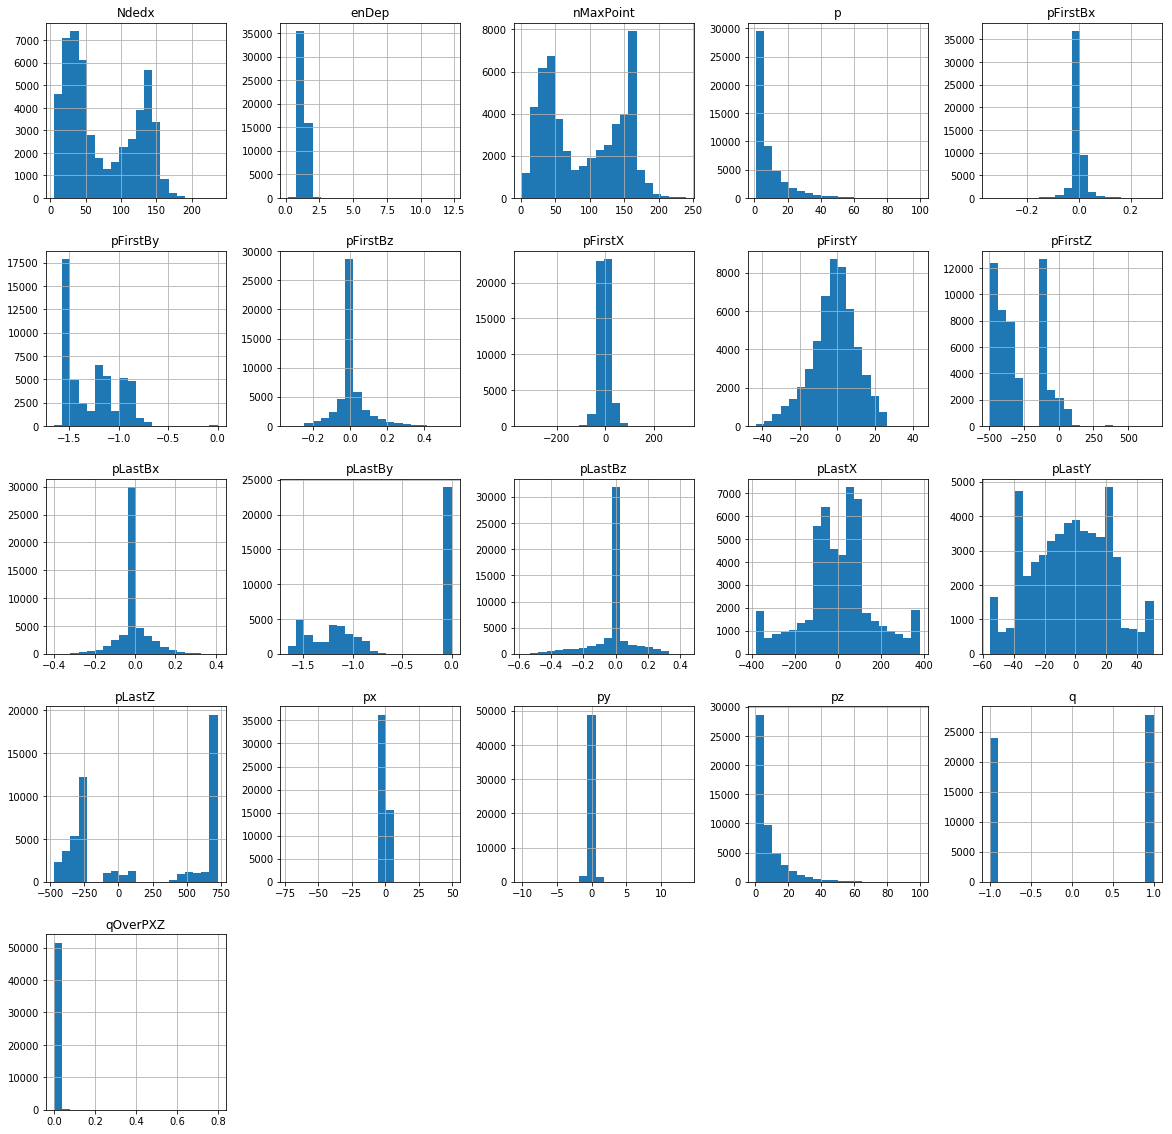

In [3]:
_ = datapd.hist(figsize=(20,20), bins=20)

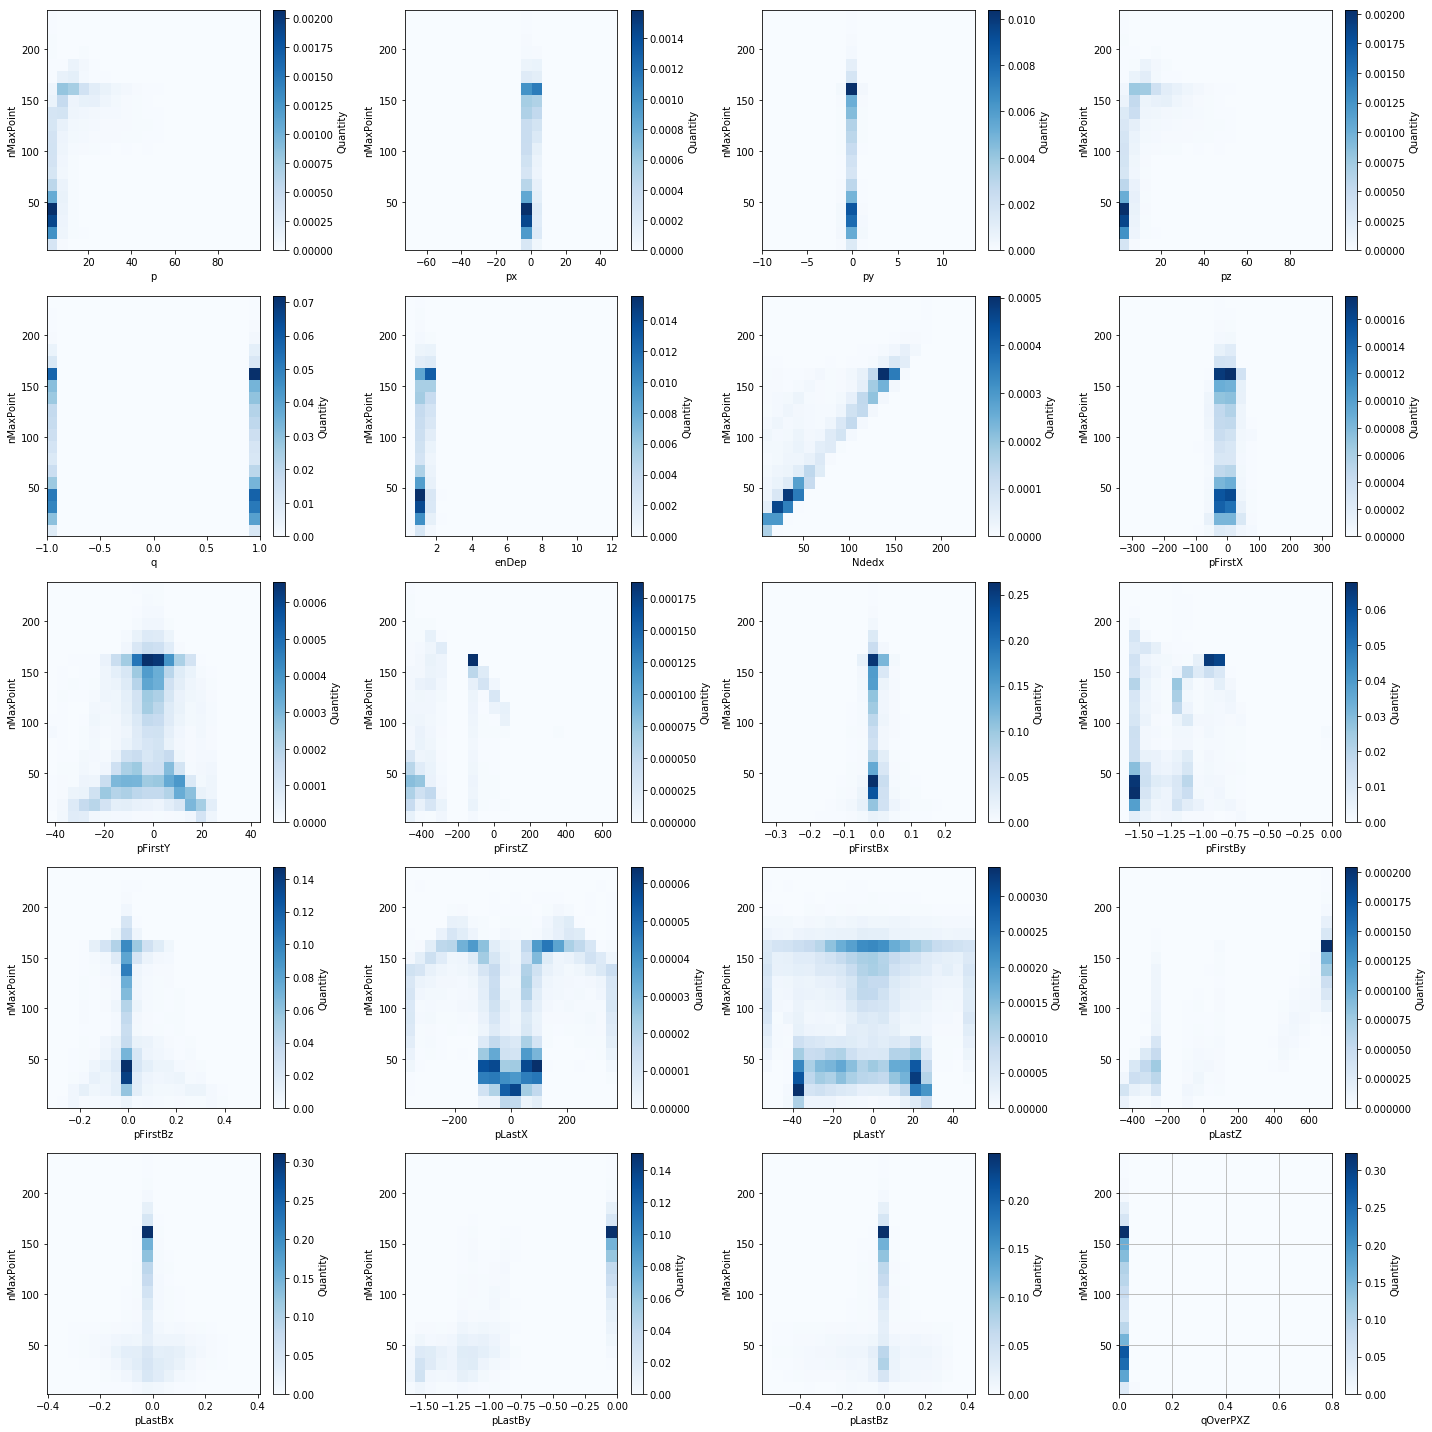

In [4]:
from matplotlib.colors import LogNorm

i=1
plt.figure(figsize=(20,20))
for key in datapd.drop("nMaxPoint", axis=1).keys():
    plt.subplot(5,4,i)
    i+=1
    plt.hist2d(x=datapd[key], y=datapd['nMaxPoint'], bins=20, cmap=plt.cm.Blues, normed=LogNorm())
    plt.xlabel(key)
    plt.ylabel('nMaxPoint')
    plt.colorbar().set_label('Quantity')
    plt.tight_layout()
plt.grid()
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X, y = np.array(datapd.drop('nMaxPoint', axis=1)), np.array(datapd['nMaxPoint'])
print(y.shape)

# y = to_categorical(y)
# print(y.shape)

train, test, train_label, test_label = train_test_split(X, y, shuffle=True, test_size=0.25)

(51796,)


In [29]:
avg, std = np.zeros(train.shape[1]), np.zeros(train.shape[1])

for i in range(train.shape[1]):
    avg[i] = np.mean(train[:, i])
    std[i] = np.std(train[:, i])
    
train_normalized = (train - avg)/std
test_normalized = (test - avg)/std

In [30]:
from keras import optimizers, layers, models, regularizers, losses, metrics

In [46]:
drop = 0.1
model = models.Sequential()
# model.add(layers.Dense(256, activation='relu', input_shape=(train.shape[1], )))
model.add(layers.Dense(32, activation='relu', input_shape=(train.shape[1], )))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1, activation='relu'))
model.compile(loss=losses.mean_squared_error, optimizer=optimizers.Adam(lr=1e-4), metrics=[metrics.mae, metrics.mse])

In [47]:
history = model.fit(train_normalized, train_label, epochs=200, validation_split=0.2, batch_size=32)

Train on 31077 samples, validate on 7770 samples
Epoch 1/200
31077/31077 [==============================] - 4s 144us/step - loss: 1014.1556 - mean_absolute_error: 20.5149 - mean_squared_error: 1014.1556 - val_loss: 577.7554 - val_mean_absolute_error: 15.8356 - val_mean_squared_error: 577.7554
Epoch 2/200
31077/31077 [==============================] - 2s 80us/step - loss: 504.6667 - mean_absolute_error: 15.0473 - mean_squared_error: 504.6667 - val_loss: 508.9667 - val_mean_absolute_error: 15.3812 - val_mean_squared_error: 508.9667
Epoch 3/200
31077/31077 [==============================] - 2s 79us/step - loss: 438.5678 - mean_absolute_error: 13.9858 - mean_squared_error: 438.5678 - val_loss: 439.2684 - val_mean_absolute_error: 13.9941 - val_mean_squared_error: 439.2684
Epoch 4/200
31077/31077 [==============================] - 2s 74us/step - loss: 397.1548 - mean_absolute_error: 13.3498 - mean_squared_error: 397.1548 - val_loss: 449.4836 - val_mean_absolute_error: 15.1617 - val_mean_squa

Epoch 68/200
31077/31077 [==============================] - 2s 69us/step - loss: 213.5701 - mean_absolute_error: 9.3748 - mean_squared_error: 213.5701 - val_loss: 245.1472 - val_mean_absolute_error: 9.7385 - val_mean_squared_error: 245.1472
Epoch 69/200
31077/31077 [==============================] - 2s 71us/step - loss: 212.9067 - mean_absolute_error: 9.3548 - mean_squared_error: 212.9067 - val_loss: 242.9335 - val_mean_absolute_error: 9.6215 - val_mean_squared_error: 242.9335
Epoch 70/200
31077/31077 [==============================] - 2s 68us/step - loss: 212.7129 - mean_absolute_error: 9.3372 - mean_squared_error: 212.7129 - val_loss: 244.2027 - val_mean_absolute_error: 9.6675 - val_mean_squared_error: 244.2027
Epoch 71/200
31077/31077 [==============================] - 2s 76us/step - loss: 211.7150 - mean_absolute_error: 9.3011 - mean_squared_error: 211.7150 - val_loss: 251.9820 - val_mean_absolute_error: 10.2127 - val_mean_squared_error: 251.9820
Epoch 72/200
31077/31077 [=========

Epoch 102/200
31077/31077 [==============================] - 2s 78us/step - loss: 198.5079 - mean_absolute_error: 8.9210 - mean_squared_error: 198.5079 - val_loss: 237.5150 - val_mean_absolute_error: 9.5794 - val_mean_squared_error: 237.5150
Epoch 103/200
31077/31077 [==============================] - 2s 75us/step - loss: 199.2933 - mean_absolute_error: 8.9275 - mean_squared_error: 199.2933 - val_loss: 240.6943 - val_mean_absolute_error: 9.7954 - val_mean_squared_error: 240.6943
Epoch 104/200
31077/31077 [==============================] - 2s 77us/step - loss: 198.8827 - mean_absolute_error: 8.9148 - mean_squared_error: 198.8827 - val_loss: 237.0928 - val_mean_absolute_error: 9.6511 - val_mean_squared_error: 237.0928
Epoch 105/200
31077/31077 [==============================] - 2s 79us/step - loss: 198.2466 - mean_absolute_error: 8.9099 - mean_squared_error: 198.2466 - val_loss: 237.4155 - val_mean_absolute_error: 9.4393 - val_mean_squared_error: 237.4155
Epoch 106/200
31077/31077 [=====

Epoch 136/200
31077/31077 [==============================] - 3s 87us/step - loss: 189.7314 - mean_absolute_error: 8.6583 - mean_squared_error: 189.7314 - val_loss: 227.0547 - val_mean_absolute_error: 9.0157 - val_mean_squared_error: 227.0547
Epoch 137/200
31077/31077 [==============================] - 3s 86us/step - loss: 188.8743 - mean_absolute_error: 8.5975 - mean_squared_error: 188.8743 - val_loss: 228.8230 - val_mean_absolute_error: 9.1462 - val_mean_squared_error: 228.8230
Epoch 138/200
31077/31077 [==============================] - 3s 96us/step - loss: 189.2810 - mean_absolute_error: 8.6446 - mean_squared_error: 189.2810 - val_loss: 225.5718 - val_mean_absolute_error: 9.1300 - val_mean_squared_error: 225.5718
Epoch 139/200
31077/31077 [==============================] - 2s 73us/step - loss: 188.8140 - mean_absolute_error: 8.6219 - mean_squared_error: 188.8140 - val_loss: 236.4323 - val_mean_absolute_error: 9.5787 - val_mean_squared_error: 236.4323
Epoch 140/200
31077/31077 [=====

Epoch 170/200
31077/31077 [==============================] - 2s 73us/step - loss: 182.0698 - mean_absolute_error: 8.4090 - mean_squared_error: 182.0698 - val_loss: 224.5753 - val_mean_absolute_error: 9.0940 - val_mean_squared_error: 224.5753
Epoch 171/200
31077/31077 [==============================] - 2s 70us/step - loss: 182.5003 - mean_absolute_error: 8.4407 - mean_squared_error: 182.5003 - val_loss: 221.0835 - val_mean_absolute_error: 8.8737 - val_mean_squared_error: 221.0835
Epoch 172/200
31077/31077 [==============================] - 2s 67us/step - loss: 181.9971 - mean_absolute_error: 8.4049 - mean_squared_error: 181.9971 - val_loss: 223.9572 - val_mean_absolute_error: 9.0919 - val_mean_squared_error: 223.9572
Epoch 173/200
31077/31077 [==============================] - 2s 67us/step - loss: 181.5092 - mean_absolute_error: 8.3834 - mean_squared_error: 181.5092 - val_loss: 224.6108 - val_mean_absolute_error: 8.9090 - val_mean_squared_error: 224.6108
Epoch 174/200
31077/31077 [=====

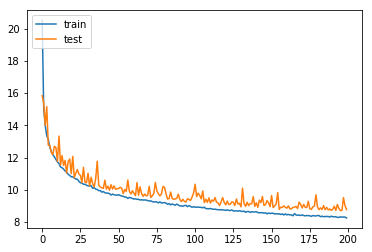

In [48]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

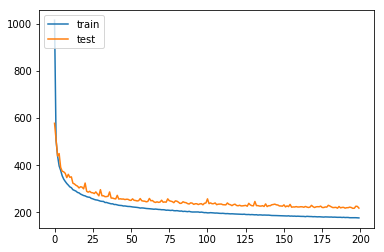

In [49]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
prediction = model.predict(test_normalized)

In [51]:
prediction[:10].astype(np.int64).flatten()

array([ 22, 200,  61, 162,  33, 105,  36, 118, 139, 165], dtype=int64)

In [52]:
(prediction.astype(np.int64).flatten()==test_label).sum()/train_label.shape[0]*100

1.9255026128143744

In [53]:
# model.save_weights('linear.h5')

In [14]:
# test_label[:10]

In [15]:
test_label[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [16]:
model2 = models.Sequential()
model2.add(layers.Dense(256, activation='relu', input_shape=(train.shape[1], )))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(256))
model2.add(layers.Dense(test_label.shape[1], activation='softmax'))
model2.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=1e-4), metrics=[metrics.mae, metrics.mse])

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
history2 = model2.fit(train_normalized, train_label, epochs=200, validation_split=0.2, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Train on 31077 samples, validate on 7770 samples
Epoch 1/200
31077/31077 [==============================] - 19s 614us/step - loss: 4.2019 - mean_absolute_error: 0.0081 - mean_squared_error: 0.0041 - val_loss: 3.9088 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 0.0040
Epoch 2/200
31077/31077 [==============================] - 18s 595us/step - loss: 3.7948 - mean_absolute_error: 0.0080 - mean_squared_error: 0.0040 - val_loss: 3.7354 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 0.0040
Epoch 3/200
31077/31077 [==============================] - 17s 542us/step - loss: 3.6703 - mean_absolute_error: 0.0079 - mean_squared_error: 0.0040 - val_loss: 3.7017 - val_mean_absolute_error: 0.0079 - val_mean_squared_error: 0.0040: 0.0079 - mean_squ - ETA: 2s - l
Epoch 4/200
31077/31077 [==============================] - 18s 570us/step - loss: 3.6104 - mean_absolute_error: 0.0079 - mean_squared_error: 0.0040 - val_loss: 3.5985 -

Epoch 69/200
31077/31077 [==============================] - 16s 526us/step - loss: 2.9449 - mean_absolute_error: 0.0075 - mean_squared_error: 0.0038 - val_loss: 3.2725 - val_mean_absolute_error: 0.0076 - val_mean_squared_error: 0.0038
Epoch 70/200
31077/31077 [==============================] - 16s 528us/step - loss: 2.9302 - mean_absolute_error: 0.0075 - mean_squared_error: 0.0038 - val_loss: 3.2528 - val_mean_absolute_error: 0.0076 - val_mean_squared_error: 0.0038
Epoch 71/200
31077/31077 [==============================] - 17s 544us/step - loss: 2.9203 - mean_absolute_error: 0.0075 - mean_squared_error: 0.0038 - val_loss: 3.2461 - val_mean_absolute_error: 0.0076 - val_mean_squared_error: 0.0038
Epoch 72/200
31077/31077 [==============================] - 18s 573us/step - loss: 2.9274 - mean_absolute_error: 0.0075 - mean_squared_error: 0.0038 - val_loss: 3.2837 - val_mean_absolute_error: 0.0076 - val_mean_squared_error: 0.0039
Epoch 73/200
31077/31077 [==============================] - 

31077/31077 [==============================] - 16s 526us/step - loss: 2.7473 - mean_absolute_error: 0.0074 - mean_squared_error: 0.0037 - val_loss: 3.2513 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 0.0038
Epoch 138/200
31077/31077 [==============================] - 16s 511us/step - loss: 2.7573 - mean_absolute_error: 0.0074 - mean_squared_error: 0.0037 - val_loss: 3.2224 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 0.0038
Epoch 139/200
31077/31077 [==============================] - 16s 518us/step - loss: 2.7437 - mean_absolute_error: 0.0073 - mean_squared_error: 0.0037 - val_loss: 3.2487 - val_mean_absolute_error: 0.0076 - val_mean_squared_error: 0.0039
Epoch 140/200
31077/31077 [==============================] - 17s 545us/step - loss: 2.7510 - mean_absolute_error: 0.0074 - mean_squared_error: 0.0037 - val_loss: 3.2152 - val_mean_absolute_error: 0.0075 - val_mean_squared_error: 0.0038
Epoch 141/200
31077/31077 [==============================] - 18s 564us

In [18]:
prediction2 = model2.predict(test_normalized)

In [19]:
prediction2[0].argmax()

151

In [20]:
test_label[0].argmax()

147

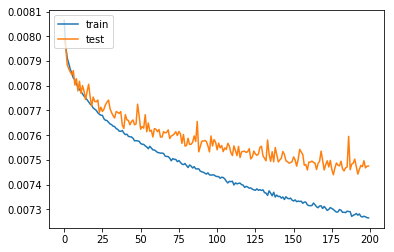

In [21]:
plt.plot(history2.history['mean_absolute_error'])
plt.plot(history2.history['val_mean_absolute_error'])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

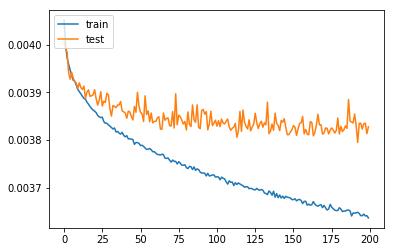

In [22]:
plt.plot(history2.history['mean_squared_error'])
plt.plot(history2.history['val_mean_squared_error'])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
# for i in range(20):
    print("pred: %d, test: %d" % (prediction2[i].argmax(), test_label[i].argmax()))

pred: 151, test: 147
pred: 21, test: 14
pred: 25, test: 30
pred: 49, test: 44
pred: 40, test: 39
pred: 139, test: 140
pred: 158, test: 159
pred: 49, test: 49
pred: 60, test: 58
pred: 154, test: 152
pred: 136, test: 136
pred: 62, test: 58
pred: 44, test: 43
pred: 161, test: 161
pred: 26, test: 30
pred: 66, test: 62
pred: 94, test: 98
pred: 151, test: 148
pred: 51, test: 52
pred: 49, test: 38


In [25]:
(prediction2.argmax(axis=1)==test_label.argmax(axis=1)).sum()/train_label.shape[0]*100

5.189589929724303

In [27]:
# model2.save_weights('logistic.h5')